In [17]:
import os
import sys
import re
import pandas as pd
import numpy as np
from fuzzywuzzy import process
import fuzzywuzzy as fw

In [18]:
path = r'P:\MyWork\product-recomender'

In [19]:
files = [x for x in os.listdir(path+'\data\\raw') if 'extract' in x]
files

['extract_1415.xlsx',
 'extract_2018.xlsx',
 'extract_1213.xlsx',
 'extract_2016.xlsx',
 'extract_2017b.xlsx',
 'extract_2017a.xlsx']

In [20]:
def combine_files(path, files):
    output_list = []
    
    # for loop to read each excel file and extract data sheet. 
    for file in files:
        
        print('\rReading "%s"' %file, end='')
        wb = pd.read_excel(path+file, sheetname=['Main Page'], skiprows=4, index_col=None)
        output_list.append(wb['Main Page'])

    print('\n\t combining files...')   
    # concatentate df's to one
    df = pd.concat(output_list)
    df.sort_values(by='Policy YOA', ascending=True, inplace=True) # sort values in order of YOA
    df.reset_index(drop=True, inplace=True)

    print('\t standardising column names and values...') 
    # basic cleaning of column names
    df.rename(columns=lambda x: x.replace(" ", "_").lower(), inplace=True) #lower case and remove spaces in names
    return df

In [21]:
dat = combine_files(path+'\data\\raw\\', files)
print(len(dat))
dat.dropna(subset=['insured_party', 'department'], inplace=True)
print(len(dat))

Reading "extract_2017a.xlsx"
	 combining files...
	 standardising column names and values...
119403
119403


In [22]:
dat.to_csv(path+'\data\\processed\\eb-extracts.txt', sep='|', encoding='utf-8')

In [23]:
dat.columns

Index(['policy_reference', 'policy_yoa', 'additional_insured_party',
       'insured_party', 'section_reference', 'department', 'trifocus',
       'coverage_name', 'class_of_business', 'additional_insured_party.1',
       'insured_item', 'original_insured', 'insured_party.1'],
      dtype='object')

In [24]:
# function to remove stop words
filename = r'P:\MyWork\product-recomender\data\processed\stopwords'

#Read
with open(filename, 'r') as f:
    stopwords = [line.rstrip("\n").replace("\'", "") for line in f]
stopwords = list(set(stopwords))

In [25]:
def stops(list_of_strings, stopwords):
    cleaned = [x for x in list_of_strings if x not in stopwords]
    cleaned = ' '.join(cleaned)
    return cleaned

In [30]:
sam = dat[['insured_party','department', 'trifocus', 'coverage_name', 'class_of_business']].copy()
sam[:3]

,insured_party,department,trifocus,coverage_name,class_of_business
0,CITY OF MIAMI,Property,Open Market,Primary,Primary
1,LOWIS & GELLEN LLP,Specialty Lines,EPL,Specialty Lines US Terrorism (TRIA),Specialty Lines US Terrorism (TRIA)
2,ISLAND CAPITAL GROUP LLC,Property,Open Market,Primary,Primary


In [31]:
sam = dat[['insured_party','department', 'trifocus', 'coverage_name', 'class_of_business']].copy()
for col in sam.columns:
    sam[col]= sam[col].str.lower()
    sam[col].replace('[^0-9a-zA-Z ]', '', regex=True, inplace=True)
sam[:7]

,insured_party,department,trifocus,coverage_name,class_of_business
0,city of miami,property,open market,primary,primary
1,lowis gellen llp,specialty lines,epl,specialty lines us terrorism tria,specialty lines us terrorism tria
2,island capital group llc,property,open market,primary,primary
3,apr energy plc,property,engineering,ear material damage annual,ear material damage annual
4,j vineyards winery lp,marine,war,marine us terrorism tria,marine us terrorism tria
5,beaumont physicians ins co,specialty lines,specialty embedded,embedded breach response,embedded breach response
6,j vineyards winery lp,marine,cargo,cargo specie,cargo specie


In [32]:
sam['insured'] = sam['insured_party'].copy()
sam['insured'] = sam['insured'].str.split(' ').apply(stops, stopwords=stopwords)
sam['insured'] = sam['insured'].str.strip()
sam['num'] = 1
sam['idx']= sam.index
sam[:7]

,insured_party,department,trifocus,coverage_name,class_of_business,insured,num,idx
0,city of miami,property,open market,primary,primary,city miami,1,0
1,lowis gellen llp,specialty lines,epl,specialty lines us terrorism tria,specialty lines us terrorism tria,lowis gellen,1,1
2,island capital group llc,property,open market,primary,primary,island capital group,1,2
3,apr energy plc,property,engineering,ear material damage annual,ear material damage annual,apr energy,1,3
4,j vineyards winery lp,marine,war,marine us terrorism tria,marine us terrorism tria,j vineyards winery,1,4
5,beaumont physicians ins co,specialty lines,specialty embedded,embedded breach response,embedded breach response,beaumont physicians ins,1,5
6,j vineyards winery lp,marine,cargo,cargo specie,cargo specie,j vineyards winery,1,6


In [203]:
path

'P:\\MyWork\\product-recomender'

# Syndicate-COB

In [247]:
cobs = pd.read_csv(path+'\\references\\cobs.csv')
cobs['tf'] = cobs['TriFocusGroup'].str.extract('(?<={)(.*)(?=})', expand=False).str.lower().copy()
cobs[:4]

,TriFocusGroup,SyndicateCOBName,tf
0,800 {Energy PD},Split GoM / Non GoM,energy pd
1,799 {Energy Liab and CAS},Split GoM / Non GoM,energy liab and cas
2,802 {Marine Libs},Marine Libs,marine libs
3,957 {Aviation PD},Split Airlines / GA,aviation pd


In [258]:
mapp = cobs.groupby(['tf','SyndicateCOBName']).agg({'tf':'count'})
mapp.rename(columns={'tf':'count'}, inplace=True)
mapp = pd.DataFrame(mapp.to_records())
mapp.rename(columns={'SyndicateCOBName':'syn-tf'}, inplace=True)
mapp[:5]

,tf,syn-tf,count
0,aviation liab,Split Airlines / GA,1
1,aviation pd,Split Airlines / GA,1
2,bbr services (exc pe),TMB Cyber,1
3,bbr services embedded,Treaty (Specialty),1
4,bbr services int (exc pe),TMB Cyber,1


In [265]:
sam['syn-tf']=np.nan
for tf in mapp['tf'].unique():
    sam.loc[sam['trifocus']==tf, 'syn-tf'] = mapp.loc[mapp['tf']==tf, 'syn-tf'].unique()[0]
    

### Remove duplications

In [268]:
dat = sam.groupby(['insured', 'syn-tf']).agg({'num':'sum'})
dat = pd.DataFrame(dat.to_records())
dat['insured'].replace('', np.nan, inplace=True)
dat.dropna(subset=['insured'], inplace=True)

# Network Analysis

In [298]:
import matplotlib.pyplot as plt
import networkx as nx
import community
% matplotlib inline

https://stackoverflow.com/questions/49429594/pyhton-pandas-dataframe-to-adjacency-matrix

In [299]:
# Calculate Matrix
col = 'syn-tf'

tf = dat[[col]+['insured']]
df_merge = tf.merge(tf, on='insured')
results = pd.crosstab(df_merge[col+'_x'], df_merge[col+'_y'])

node_weights = np.array(np.diagonal(results.values))
np.fill_diagonal(results.values, 0)

#results.to_csv('P:\MyWork\product-recomender\gephi\trifocus_matrix.csv')
results.loc[:'Cat',:'Cat']

syn-tf_y,Accident,Cargo,Cat
syn-tf_x,,,
Accident,0,2,31
Cargo,2,0,1
Cat,31,1,0


In [373]:
results.to_csv('dat.csv')

# Network

In [341]:
adjacency = np.array(results)
G = nx.from_numpy_matrix(adjacency, create_using=nx.Graph()) # create graph

labels = list(results.columns)
labels = {e: i for (e, i) in enumerate(labels)}
G = nx.relabel_nodes(G,labels) # relabel nodes

## Nodes

In [317]:
d = nx.degree(G)
node_degree= np.array([i[1] for i in d])

## Edges

In [318]:
edges = G.edges()
edge_weights = np.array([G[u][v]['weight'] for u,v in edges])
edge_norm = (edge_weights-min(edge_weights))/(max(edge_weights)-min(edge_weights))

## Components

In [356]:
sg = [G.subgraph(c) for c in nx.connected_components(G)]

## Communities

In [349]:
part = community.best_partition(G, resolution=1)
parts = [part.get(node) for node in G.nodes()]

## Plot

In [370]:
def plot_graph(graph, axis):
    deg = nx.degree(graph)
    node_degree= np.array([i[1] for i in deg])
    edges = graph.edges()
    edge_weights = np.array([graph[u][v]['weight'] for u,v in edges])
    edge_norm = (edge_weights-min(edge_weights))/(max(edge_weights)-min(edge_weights))
    part = community.best_partition(graph, resolution=1)
    parts = [part.get(node) for node in graph.nodes()]
    
    nx.draw(graph, ax=axis,
            pos=nx.spring_layout(graph, center=(1,1), k=15),
            node_size=node_weights/2, with_labels=True,
            cmap = plt.get_cmap('jet'), node_color = parts,
            edgelist=edges, width=edge_norm*30)

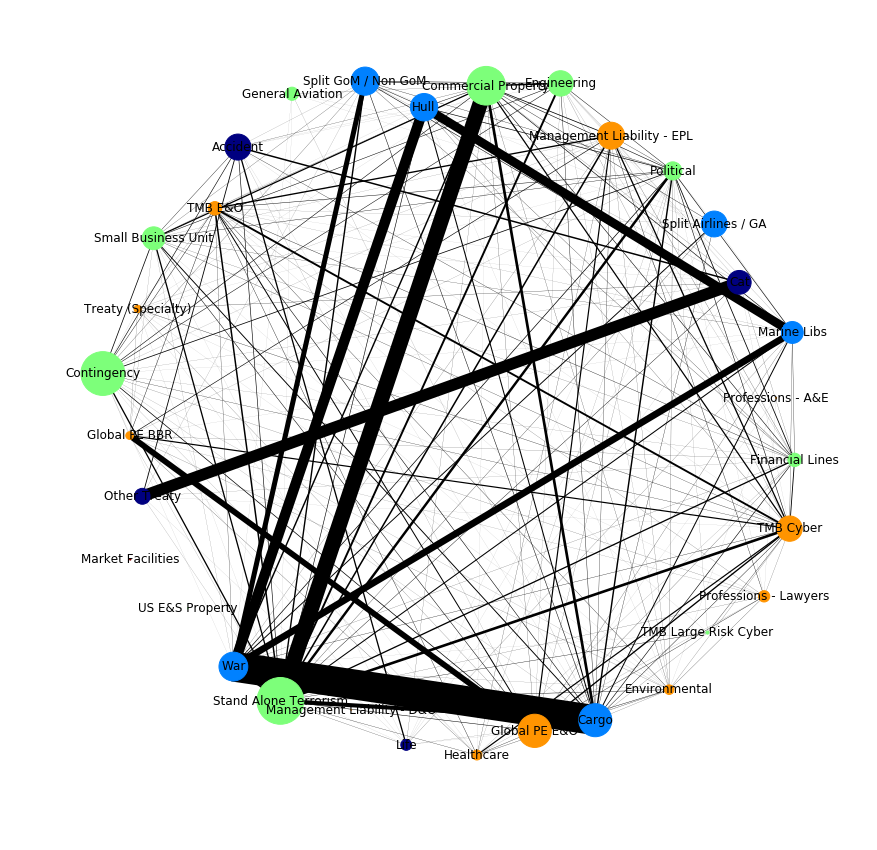

In [372]:
fig, axs = plt.subplots(1,1, figsize=(15,15))
plot_graph(G, axs)